In [15]:
from sklearnex import patch_sklearn 
patch_sklearn()

# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

# Randomforest Regression
from sklearn.ensemble import RandomForestRegressor

# Support Vector Regression
from sklearn.svm import SVR

# hyper parameter tunning
from sklearn.model_selection import GridSearchCV

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [16]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 31 16:43:28 2022

@author: Junhyun
"""
class TimeSeriesRegression():
    
    def __init__(self):
        self.data = None
    
    def TimeSeriesDataTransform(self, data, lag):
        """
        # 참조 코드 : http://103.60.126.183:8150/gidatalab (LSTM)
        
        데이터를 변환하기 위해서는 Y값이 맨 왼쪽에 위치해있어야함 
        
        To transoform data to timeseries data, target data(Y) have to be located at leftmost
    
        Parameters
        ----------
        data : DataFrame
            data
        lag : int
            시계열 예측에서 데이터를 미는 시점 (= Time sequence)

        Returns
        -------
        agg : 시계열 에측이 가능하도록 변환된 데이터

        """
        if isinstance(self.data, np.ndarray):
            data = pd.DataFrame(self.data)
        elif isinstance(self.data, pd.core.series.Series):
            data = pd.DataFrame(self.data)
        
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)

        cols, names = list(), list()

        # 입력값의 순서 (t-n, ... t-1)
        for i in range(lag, 0, -1):
            cols.append(df.shift(i))
            names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

        # 예측의 순서 (t, t+1, ... t+n)
        for i in range(0, 1):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
            else:
                names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]

        # 합치기
        agg = pd.concat(cols, axis=1)
        agg.columns = names

        # NaN 값의 row를 제거
        agg.dropna(inplace=True)
        
        # 인덱스 초기화
        agg = agg.reset_index(drop=True)
        
        agg = agg.iloc[:,0:(data.shape[1]*lag)+1]

        return agg

        
    # Ridge Regression
    def Ridge_regression(self, X_train, X_test, y_train, y_test):

        alphas = np.arange(0, 1, 0.03)
        ridgecv = RidgeCV(alphas = alphas, cv = 5) 
        ridgecv.fit(X_train, y_train)
        print("alpha : %.2f" % ridgecv.alpha_)

        ridge_train_pred = ridgecv.predict(X_train)
        ridge_test_pred = ridgecv.predict(X_test)

        return({'trainPrediction':ridge_train_pred, 'testPrediction':ridge_test_pred})
    
    # Random Forest Regression
    def Randomforest_regression(self, X_train, X_test, y_train, y_test):

        params = {
            'n_estimators' : [100],
            'max_depth' : [6,8,10,12],
            'min_samples_leaf' : [8,12,8],
            'min_samples_split' : [8,16,20]
        }

        rf = RandomForestRegressor()
        grid_cv = GridSearchCV(rf, param_grid=params, cv=5)
        grid_cv.fit(X_train, y_train)
        print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)

        rf_train_pred = grid_cv.predict(X_train)
        rf_test_pred = grid_cv.predict(X_test)

        return({'trainPrediction':rf_train_pred, 'testPrediction':rf_test_pred})
    
    # Support Vector Regression
    def Supportvector_regression(self, X_train, X_test, y_train, y_test):

        param_grid = [
            {'kernel':['linear'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
            {'kernel':['rbf'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
            {'gamma':[0.0001, 0.001, 0.01, 0.1, 1.0]}
        ]
        svr = SVR()
        grid_cv = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
        grid_cv.fit(X_train, y_train)
        print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)

        svr_train_pred = grid_cv.predict(X_train)
        svr_test_pred = grid_cv.predict(X_test)

        return({'trainPrediction':svr_train_pred, 'testPrediction':svr_test_pred})

    def LSTM_model(self, X_train, X_test, y_train, y_test, epochs=50):
        """

        Parameters
        ----------
        X_train : Array
            Train input data, shape=(nrow, lag, ncol)
        X_test : Array
            Test input data, shape=(nrow, lag, ncol)
        y_train : Array
            Train input data, shape=(nrow,)
        y_test : Array
            Train input data, shape=(nrow,)
        epochs : int
            LSTM 학습횟수

        Returns
        -------
        trainPrediction : Array
            Train Prediction
        testPrediction : Array
            Test Prediction

        """


        # LSTM의 구조
        model = Sequential()
        model.add(LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu')) # 하나의 층 8개의 노드, return_sequences=True 필수
        model.add(LSTM(4, activation='relu', return_sequences=False)) # 하나의층, 4개의 노드, 마지막에는 return_sequences=False
        model.add(Dense(1)) # 노드가 하나인 구조를 만들었다 (하나의 예측값으로 표현하기 위해)

        # model compile
        model.compile(loss='mse', optimizer='adam')

        # fit network
        history = model.fit(X_train, y_train, epochs=epochs, verbose=0, shuffle=False) # epochs : 반복횟수

        lstm_train_pred = model.predict(X_train)
        lstm_test_pred = model.predict(X_test)

        return({'trainPrediction':lstm_train_pred, 'testPrediction':lstm_test_pred})

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

In [19]:
iris = load_iris(as_frame=True)
data = iris['data']
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [20]:
# 클래스 선언
ts = TimeSeriesRegression()

lag = 3
reframed = ts.TimeSeriesDataTransform(data, lag=lag)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(reframed.iloc[:,0:-1], reframed.iloc[:,-1], test_size=0.3, shuffle=False)

In [36]:
# Timeseries Ridge Regression
ridge = ts.Ridge_regression(X_train, X_test, y_train, y_test)

alpha : 0.99


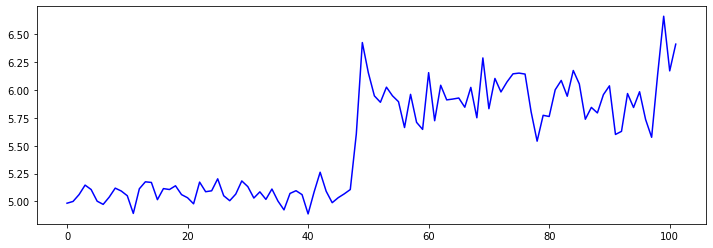

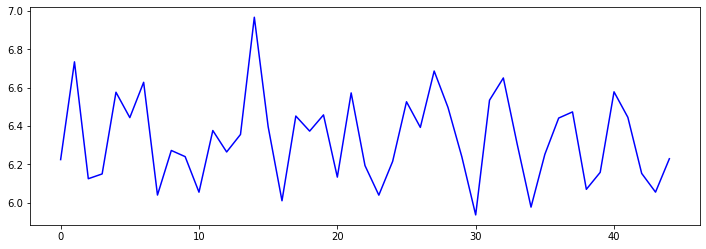

In [38]:
# train Fit
plt.figure(figsize=(12,4))
plt.plot(ridge['trainPrediction'], color='blue')
plt.show()

# test Fit
plt.figure(figsize=(12,4))
plt.plot(ridge['testPrediction'], color='blue')
plt.show()

In [24]:
# Timeseries Random Forest
rf = ts.Randomforest_regression(X_train, X_test, y_train, y_test)

최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}


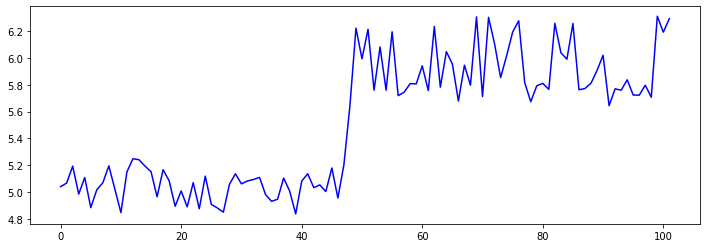

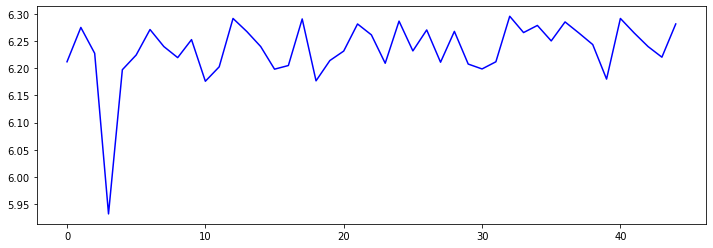

In [35]:
# train Fit
plt.figure(figsize=(12,4))
plt.plot(rf['trainPrediction'], color='blue')
plt.show()

# test Fit
plt.figure(figsize=(12,4))
plt.plot(rf['testPrediction'], color='blue')
plt.show()

In [25]:
# Timeseries Support Vector Regression
svr = ts.Supportvector_regression(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
최적 하이퍼 파라미터:
 {'C': 0.01, 'kernel': 'linear'}


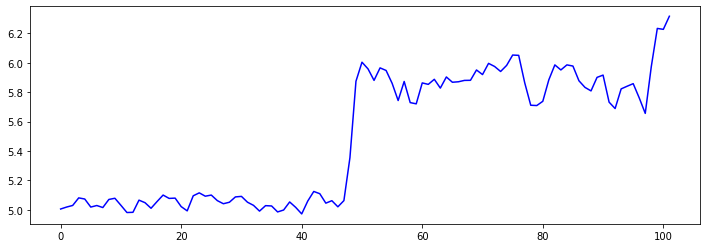

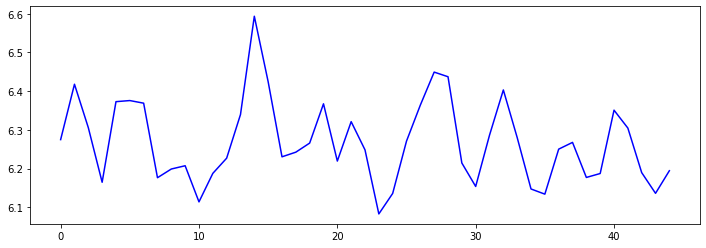

In [37]:
# train Fit
plt.figure(figsize=(12,4))
plt.plot(svr['trainPrediction'], color='blue')
plt.show()

# test Fit
plt.figure(figsize=(12,4))
plt.plot(svr['testPrediction'], color='blue')
plt.show()

In [31]:
# LSTM
lstm = ts.LSTM_model(X_train.values.reshape(X_train.shape[0], lag, data.shape[1]), X_test.values.reshape(X_test.shape[0], lag, data.shape[1]), y_train, y_test, epochs=10)

2022-08-01 07:12:22.049167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-01 07:12:22.049198: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-01 07:12:22.049234: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-08-01 07:12:22.049528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with

2/2 [==============================] - 0s 4ms/step


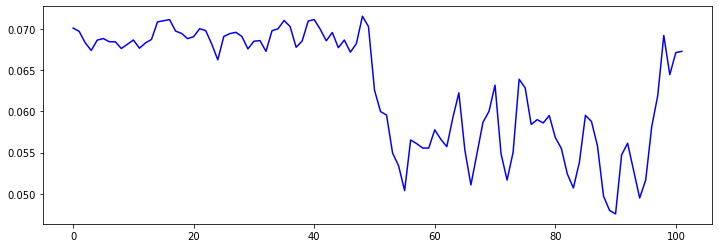

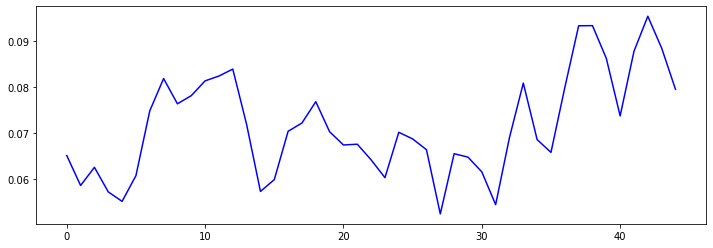

In [39]:
# train Fit
plt.figure(figsize=(12,4))
plt.plot(lstm['trainPrediction'], color='blue')
plt.show()

# test Fit
plt.figure(figsize=(12,4))
plt.plot(lstm['testPrediction'], color='blue')
plt.show()